<a href="https://www.kaggle.com/code/kapturovalexander/kapturov-s-loan-approval-prediction-s4e10?scriptVersionId=199205847" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style="background-image: url(https://www.kaggle.com/competitions/84894/images/header); color: gold; font-size: 50px; padding: 10px;">Loan Approval Prediction</span>
## <span style="border: solid gold 3px; background-color: #B58050; color: white; padding: 3px">Playground Series - Season 4, Episode 10

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv


![](https://www.kaggle.com/competitions/84894/images/header)

### <span style="color: #B58050">version 1</span> - first glance at the data, without EDA
### <span style="color: #B58050">version 2</span> - I found outliers in "person_emp_length" feature
### <span style="color: #B58050">version 3</span> - Added pie plot visualization to categorical features
### <span style="color: #B58050">version 4</span> - Added pivot tables, histograms and some other things
### <span style="color: #B58050">version 5</span> - Build heatmap and convert categorical variables into dummy
### <span style="color: #B58050">version 6</span> - I planed to train 3 models (LR, SVM and KNN) and also created base for optuna tuning on XGBBoost
### <span style="color: #B58050">version 7</span> - XGB with CV (40 trials)
### <span style="color: #B58050">version 8</span> - XGBoost with CV (100 trials - 0.8654 on valid)
### <span style="color: #B58050">version 9</span> - Catboost with CV (50 trials - 0.8653 on valid)
### <span style="color: #B58050">version 10</span> - Concatenated Train + Original (filled NaN gaps). XGBoost with CV (50 Optuna trials - 0.8640 on valid)

## 🪙 <span style="color: #B58050">Starting from this competition I will return to daily activity on kaggle because I need to become a strong professional in machine learning and data science. I hope this notebook will be the best among my previous ones and my results at the end of the competition will be good!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 'id' feature is index
train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv', index_col=0)
test = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv', index_col=0)

In [4]:
# Display all features in DataFrame
pd.set_option('display.max_columns', None)

In [5]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [6]:
train.tail(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
id,,,,,,,,,,,,
58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0
58644,31,75000,MORTGAGE,2.0,VENTURE,B,15000,11.11,0.20,N,5,0


<a id="features"></a>
    
### 💵 <span style="color: #B58050">person_age</span>: Age of the person applying for the loan, measured in years.
### 💵 <span style="color: #B58050">person_income</span>: Annual income of the applicant in dollars.
### 💵 <span style="color: #B58050">person_home_ownership</span>: Type of home ownership (e.g., RENT, MORTGAGE, OWN).
### 💵 <span style="color: #B58050">person_emp_length</span> Length of employment in years (for whole life maybe).
### 💵 <span style="color: #B58050">loan_intent</span>: Purpose of the loan (e.g., EDUCATION, VENTURE, PERSONAL).
### 💵 <span style="color: #B58050">loan_grade</span>: Assigned grade to the loan indicating its risk profile (e.g., A is the best).
### 💵 <span style="color: #B58050">loan_amnt</span>: Amount of money requested by the applicant for the loan.
### 💵 <span style="color: #B58050">loan_int_rate</span>: Annual interest rate of the loan, shown as a percentage.
### 💵 <span style="color: #B58050">loan_percent_income</span>: Ratio of the loan amount to the applicant's annual income.
### 💵 <span style="color: #B58050">cb_person_default_on_file</span>: Indicator of whether the person has a history of defaulting on other credit obligations (Y for Yes, N for No).
### 💵 <span style="color: #B58050">cb_person_cred_hist_length</span>: Length of the applicant's credit history, measured in years.
### 💵 <span style="color: #B58050">loan_status</span>: Status of the loan (1 if defaulted, 0 if not).

# <span style="background-image: url(https://www.kaggle.com/competitions/84894/images/header); color: gold; font-size: 50px; padding: 10px;">EDA

In [7]:
# For visualization purposes
numeric = ['person_age', 'person_income', 'person_emp_length', 'loat_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

In [8]:
train.shape

(58645, 12)

## <span style="color: #B58050">There are 12 features (one of them is target) and about 59K observations

In [9]:
test.shape

(39098, 11)

## <span style="color: #B58050">Combine original dataset with competition's dataset

In [10]:
original = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')
original.shape

(32581, 12)

In [11]:
original.head(3)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3


In [12]:
original.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

### <span style="color: #B58050">There are many gaps in two features. First we can compare distribution of these two features among train, test and original

![](https://static.seekingalpha.com/cdn/s3/uploads/getty_images/1395728828/image_1395728828.jpg?io=getty-c-w1536)

In [13]:
train['person_emp_length'].unique()

array([  0.,   6.,   8.,  14.,   2.,   9.,  11.,   5.,   1.,  13.,   3.,
        10.,  12.,   4.,   7.,  21.,  17.,  16.,  18.,  19.,  15.,  20.,
        23.,  24.,  26.,  22.,  25.,  41.,  27.,  28.,  35.,  29.,  30.,
        31., 123.,  39.])

In [14]:
import warnings

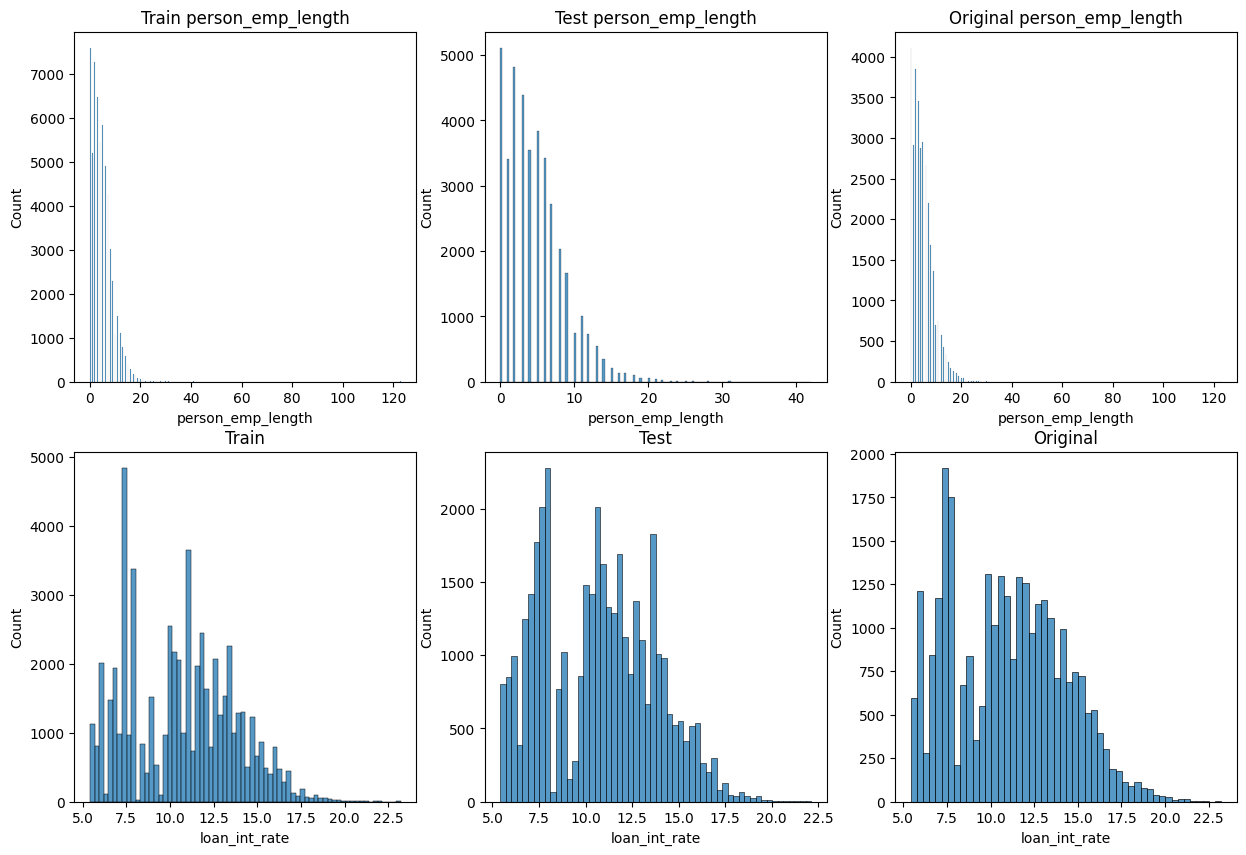

In [15]:
warnings.filterwarnings('ignore')
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

sns.histplot(train['person_emp_length'], ax=axes[0, 0])
axes[0, 0].set_title('Train person_emp_length')

sns.histplot(test['person_emp_length'], ax=axes[0, 1])
axes[0, 1].set_title('Test person_emp_length')

sns.histplot(original['person_emp_length'], ax=axes[0, 2])
axes[0, 2].set_title('Original person_emp_length')

sns.histplot(train['loan_int_rate'], ax=axes[1, 0])
axes[1, 0].set_title('Train')

sns.histplot(test['loan_int_rate'], ax=axes[1, 1])
axes[1, 1].set_title('Test')

sns.histplot(original['loan_int_rate'], ax=axes[1, 2])
axes[1, 2].set_title('Original')

plt.show()

### <span style="color: #B58050">Distributions looks really similar

In [16]:
train[['person_emp_length', 'loan_int_rate']].describe().T

,count,mean,std,min,25%,50%,75%,max
person_emp_length,58645.0,4.701015,3.959784,0.00,2.00,4.00,7.00,123.00
loan_int_rate,58645.0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22


In [17]:
original[['person_emp_length', 'loan_int_rate']].describe().T

,count,mean,std,min,25%,50%,75%,max
person_emp_length,31686.0,4.789686,4.142630,0.00,2.0,4.00,7.00,123.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.9,10.99,13.47,23.22


### <span style="color: #B58050">Statistics look similar. I'm gonna try to fill gaps with median and combine original with train

In [18]:
original['person_emp_length'] = original['person_emp_length'].fillna(original['person_emp_length'].median())
original['loan_int_rate'] = original['loan_int_rate'].fillna(original['loan_int_rate'].median())

In [19]:
original.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

### <span style="color: #B58050">I filled gaps and now there is no more gaps. Let's compare statistics of train and original:

In [20]:
train[['person_emp_length', 'loan_int_rate']].describe().T

,count,mean,std,min,25%,50%,75%,max
person_emp_length,58645.0,4.701015,3.959784,0.00,2.00,4.00,7.00,123.00
loan_int_rate,58645.0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22


In [21]:
original[['person_emp_length', 'loan_int_rate']].describe().T

,count,mean,std,min,25%,50%,75%,max
person_emp_length,32581.0,4.767994,4.087372,0.00,2.00,4.00,7.00,123.00
loan_int_rate,32581.0,11.009620,3.081611,5.42,8.49,10.99,13.11,23.22


In [22]:
train = pd.concat(objs=[train, original])
train.shape

(91226, 12)

In [23]:
train[['person_emp_length', 'loan_int_rate']].describe().T

,count,mean,std,min,25%,50%,75%,max
person_emp_length,91226.0,4.724936,4.005924,0.00,2.00,4.00,7.00,123.00
loan_int_rate,91226.0,10.796356,3.055656,5.42,7.88,10.99,12.99,23.22


![](https://images.ctfassets.net/1aemqu6a6t65/5rPsNLkgpwvZPSmjhE5ChB/9ee0978b3d792515d59fefab5296b832/wall-street-photo-tagger-yancey-iv-nyc-and-company-02-2?w=1200&h=800&q=75)

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91226 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  91226 non-null  int64  
 1   person_income               91226 non-null  int64  
 2   person_home_ownership       91226 non-null  object 
 3   person_emp_length           91226 non-null  float64
 4   loan_intent                 91226 non-null  object 
 5   loan_grade                  91226 non-null  object 
 6   loan_amnt                   91226 non-null  int64  
 7   loan_int_rate               91226 non-null  float64
 8   loan_percent_income         91226 non-null  float64
 9   cb_person_default_on_file   91226 non-null  object 
 10  cb_person_cred_hist_length  91226 non-null  int64  
 11  loan_status                 91226 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 9.0+ MB


### <span style="color: #B58050">At first glance, there are no gaps in the data.

In [25]:
train.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [26]:
test.isna().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

### <span style="color: #B58050">Yes, there are no gaps in the data.

In [27]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,91226.0,27.616480,6.148115,20.00,23.00,26.00,30.00,144.00
person_income,91226.0,64770.706224,47936.961097,4000.00,40000.00,57000.00,78000.00,6000000.00
person_emp_length,91226.0,4.724936,4.005924,0.00,2.00,4.00,7.00,123.00
loan_amnt,91226.0,9350.348607,5848.605423,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,91226.0,10.796356,3.055656,5.42,7.88,10.99,12.99,23.22
loan_percent_income,91226.0,0.163154,0.097491,0.00,0.09,0.14,0.22,0.83
cb_person_cred_hist_length,91226.0,5.810219,4.038412,2.00,3.00,4.00,8.00,30.00
loan_status,91226.0,0.169447,0.375149,0.00,0.00,0.00,0.00,1.00


### [Description of the features](#features)

### <span style="color: #B58050">About 3/4 of borrowers are people in age not above than 30. 75% of sample has income below 76k$.</span>
## <span style="color: #B58050">I also guess that observation where person_age is 123 and person_emp_length is also 123 is anomaly, so don't forget to clear the data!

### My post about this: [🤔 Anomaly or what does means ''person_emp_length'' feature?](https://www.kaggle.com/competitions/playground-series-s4e10/discussion/536990)

# 🪙 <span style="color: #B58050">Outliers detection

In [28]:
# How many years people didn't work
years_without_work = train['person_age'] - train['person_emp_length']
years_without_work.sort_values(ascending=True).head(30)

210     -102.0
49252   -102.0
0       -101.0
41079    -95.0
41912      2.0
26125      2.0
43518      6.0
746        6.0
52038      7.0
32236      8.0
24214      8.0
58602      9.0
56176      9.0
18783      9.0
33012     10.0
12638     11.0
17542     11.0
699       11.0
48118     12.0
17861     12.0
48915     12.0
34852     12.0
3072      12.0
16378     12.0
53992     12.0
48185     13.0
15921     13.0
20615     13.0
18293     13.0
8222      13.0
dtype: float64

In [29]:
train.iloc[[49252, 41079]]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
49252,21,192000,MORTGAGE,123.0,VENTURE,B,20000,11.49,0.10,N,2,0
41079,28,60350,MORTGAGE,123.0,MEDICAL,D,25000,15.95,0.35,Y,6,1


In [30]:
outliers_indexes = years_without_work.sort_values(ascending=True).head(28).index
outliers_indexes

Index([  210, 49252,     0, 41079, 41912, 26125, 43518,   746, 52038, 32236,
       24214, 58602, 56176, 18783, 33012, 12638, 17542,   699, 48118, 17861,
       48915, 34852,  3072, 16378, 53992, 48185, 15921, 20615],
      dtype='int64')

In [31]:
train.iloc[outliers_indexes]

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
210,25,33000,RENT,2.0,MEDICAL,B,4000,10.25,0.12,N,4,0
49252,21,192000,MORTGAGE,123.0,VENTURE,B,20000,11.49,0.10,N,2,0
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
41079,28,60350,MORTGAGE,123.0,MEDICAL,D,25000,15.95,0.35,Y,6,1
41912,23,48686,RENT,21.0,EDUCATION,B,12000,11.86,0.25,N,2,0
26125,43,56000,RENT,41.0,HOMEIMPROVEMENT,B,2000,10.99,0.04,N,14,0
43518,25,42000,RENT,19.0,MEDICAL,C,6000,13.49,0.14,N,4,0
746,23,100000,MORTGAGE,17.0,PERSONAL,A,17000,7.49,0.17,N,3,0
52038,38,42000,MORTGAGE,31.0,VENTURE,B,11000,11.49,0.26,N,14,0
32236,23,25596,RENT,15.0,EDUCATION,A,5000,7.90,0.20,N,4,0


### <span style="color: #B58050">I don't know at what age people in the US or other countries can start working, but I'm guessing that the 28 observations above are outliers, since their years_out_of_work are less than 14 years.

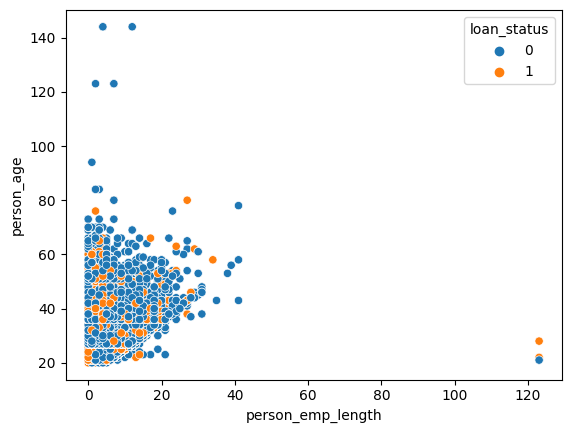

In [32]:
# Visualize outliers
sns.scatterplot(x=train['person_emp_length'], y=train['person_age'], hue=train['loan_status']);

### <span style="color: #B58050">We see that at least there are 3 outliers. But age 123 might be real age of really old person. Anyway I guess that this observation is also outlier because of number 123.

In [33]:
outliers = train.loc[(train['person_emp_length'] > 50) | (train['person_age'] > 90)]
outliers

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
41079,28,60350,MORTGAGE,123.0,MEDICAL,D,25000,15.95,0.35,Y,6,1
47336,123,36000,MORTGAGE,7.0,PERSONAL,B,6700,10.75,0.18,N,4,0
49252,21,192000,MORTGAGE,123.0,VENTURE,B,20000,11.49,0.10,N,2,0
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1
81,144,250000,RENT,4.0,VENTURE,C,4800,13.57,0.02,N,3,0
183,144,200000,MORTGAGE,4.0,EDUCATION,B,6000,11.86,0.03,N,2,0
210,21,192000,MORTGAGE,123.0,VENTURE,A,20000,6.54,0.10,N,4,0
575,123,80004,RENT,2.0,EDUCATION,B,20400,10.25,0.25,N,3,0
747,123,78000,RENT,7.0,VENTURE,B,20000,10.99,0.26,N,4,0
32297,144,6000000,MORTGAGE,12.0,PERSONAL,C,5000,12.73,0.00,N,25,0


In [34]:
print(train.shape)
train = train.drop(outliers.index)
train.shape

(91226, 12)


(91207, 12)

### <span style="color: #B58050">Outliers are now removed

![](https://banker.bg/wp-content/uploads/56b0e1f0-d857-4db4-86c1-92f575d5dde5-4.jpg)

In [35]:
train.describe(include=['object']).T

,count,unique,top,freq
person_home_ownership,91207,4,RENT,47028
loan_intent,91207,6,EDUCATION,18720
loan_grade,91207,7,A,31758
cb_person_default_on_file,91207,2,N,76762


## <span style="color: #B58050">Value counts for each categorical feature

In [36]:
for index, feature in enumerate(categorical):
    print(train[feature].value_counts(), end='\n\n')
    
    if index != len(categorical) - 1:  # Margins
        print('-' * 100)
        print()

person_home_ownership
RENT        47028
MORTGAGE    38261
OWN          5722
OTHER         196
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------

loan_intent
EDUCATION            18720
MEDICAL              17001
VENTURE              15726
PERSONAL             15534
DEBTCONSOLIDATION    14341
HOMEIMPROVEMENT       9885
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------

loan_grade
A    31758
B    30841
C    17490
D     8658
E     1973
F      390
G       97
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------

cb_person_default_on_file
N    76762
Y    14445
Name: count, dtype: int64



In [37]:
for index, feature in enumerate(categorical):
    print(train[feature].value_counts(normalize=True), end='\n\n')
    
    if index != len(categorical) - 1:  # Margins
        print('-' * 100)
        print()

person_home_ownership
RENT        0.515618
MORTGAGE    0.419496
OWN         0.062736
OTHER       0.002149
Name: proportion, dtype: float64

----------------------------------------------------------------------------------------------------

loan_intent
EDUCATION            0.205247
MEDICAL              0.186400
VENTURE              0.172421
PERSONAL             0.170316
DEBTCONSOLIDATION    0.157236
HOMEIMPROVEMENT      0.108380
Name: proportion, dtype: float64

----------------------------------------------------------------------------------------------------

loan_grade
A    0.348197
B    0.338143
C    0.191762
D    0.094927
E    0.021632
F    0.004276
G    0.001064
Name: proportion, dtype: float64

----------------------------------------------------------------------------------------------------

cb_person_default_on_file
N    0.841624
Y    0.158376
Name: proportion, dtype: float64



## <span style="color: #B58050">Only 5% of people who would like to borrow money have own real estate(s). Most frequent loan intention is for education purposes (21%)

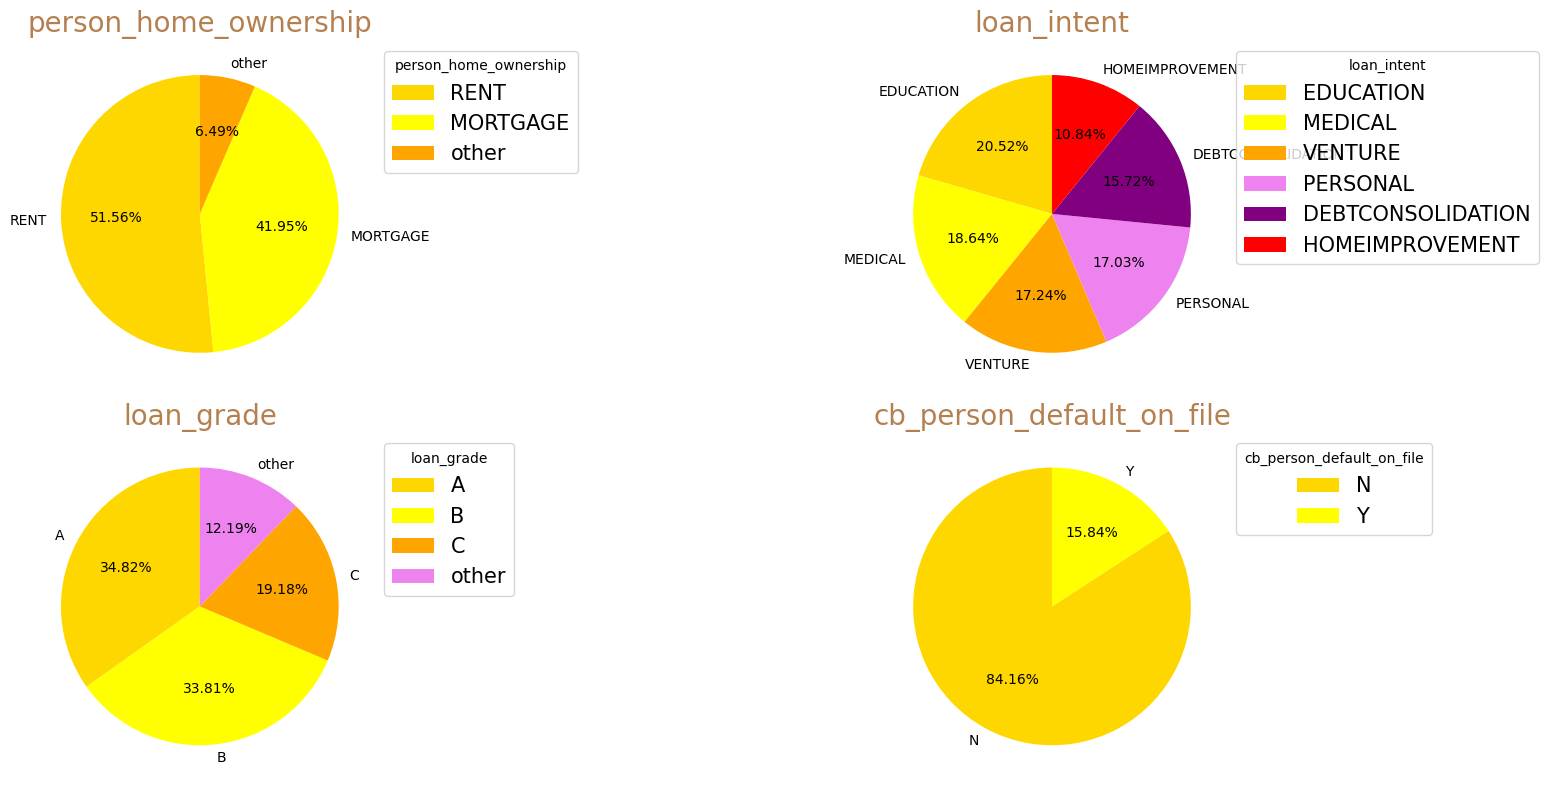

In [38]:
colors = ['gold', 'yellow', 'orange', 'violet', 'purple', 'red', 'brown']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 8))

# Threshold for small values
threshold = 0.10

for index, feature in enumerate(categorical):
    label_count = train[feature].value_counts()
    
    # Calculate shares for each group
    label_percent = label_count / label_count.sum()
    
    # Group the values
    other_count = label_count[label_percent < threshold].sum()
    label_count = label_count[label_percent >= threshold]
    
    # Add category "other", if total share less than 10%
    if other_count > 0:
        label_count['other'] = other_count
    
    row, col = divmod(index, 2)
    
    wedges, texts, autotexts = axes[row, col].pie(
        x=label_count, 
        labels=label_count.index, 
        autopct='%1.2f%%',
        startangle=90, 
        colors=colors[:len(label_count)],  # Restrict number of colors
    )
    
    axes[row, col].set_title(feature, color='#B58050', fontsize=20)
    
    axes[row, col].legend(
        wedges, 
        label_count.index, 
        title=feature, 
        loc="upper left", 
        bbox_to_anchor=(1, 0, 0.5, 1), 
        fontsize=15
    )

plt.tight_layout()
plt.show()

## <span style="color: #B58050">Desine some pivot tables to analyse the data

In [39]:
pd.pivot_table(data=train, values='person_age', index='loan_grade', columns='person_home_ownership', aggfunc='count', fill_value=0)

person_home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_grade,,,,
A,17031,47,2070,12610
B,11939,74,1869,16959
C,5725,33,1078,10654
D,2718,30,582,5328
E,665,9,93,1206
F,146,2,23,219
G,37,1,7,52


### <span style="color: #B58050">Most people who has loan_grade equals to A has mortgage and people who has loan_grade equals to B rent real estates

In [40]:
pd.pivot_table(data=train, values='person_age', index='loan_intent', columns='person_home_ownership', aggfunc='count')

person_home_ownership,MORTGAGE,OTHER,OWN,RENT
loan_intent,,,,
DEBTCONSOLIDATION,6356,27,115,7843
EDUCATION,7628,34,1223,9835
HOMEIMPROVEMENT,4986,22,688,4189
MEDICAL,6014,24,902,10061
PERSONAL,6805,41,1006,7682
VENTURE,6472,48,1788,7418


## <span style="color: #B58050">Build histogram of distribution

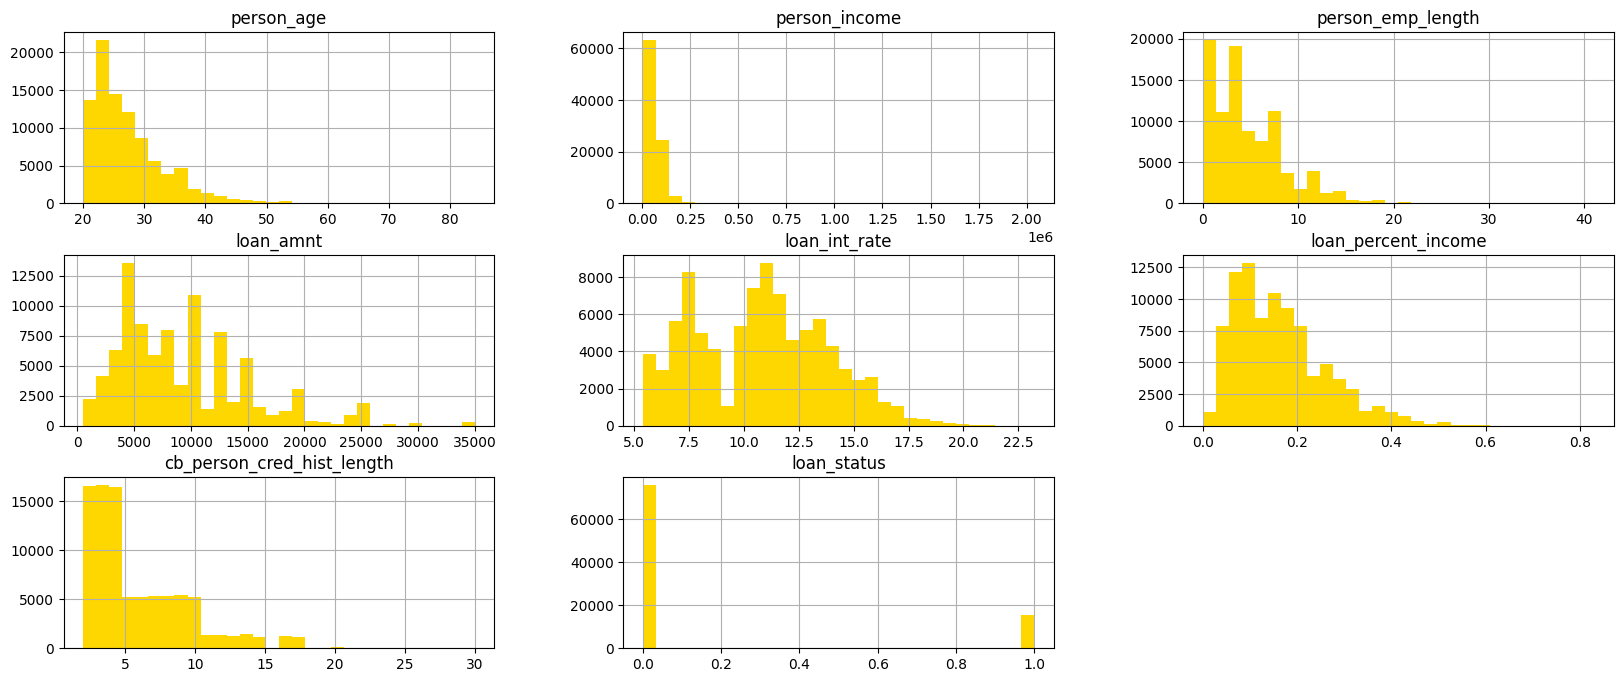

In [41]:
train.hist(figsize=(20, 8), color='gold', bins=30);

### <span style="color: #B58050">The distribution is strongly skewed to the left: most observations are concentrated in the 20-40 year range. Most people have less than 10 years of experience.

In [42]:
train = pd.get_dummies(data=train, drop_first=True)
test = pd.get_dummies(data=test, drop_first=True)

train.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
1,22,56000,6.0,4000,13.35,0.07,2,0,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False
2,29,28800,8.0,6000,8.90,0.21,10,0,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False
3,30,70000,14.0,12000,11.11,0.17,5,0,False,False,True,False,False,False,False,True,True,False,False,False,False,False,False
4,22,60000,2.0,6000,6.92,0.10,3,0,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
5,27,45000,2.0,9000,8.94,0.20,5,0,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False


## <span style="color: #B58050">Convert boolean values to numeric

In [43]:
converter = {True: 1, False: 0}
transform = lambda x: converter[x]

for column in train.columns:
    if train[column].dtype == 'bool':
        train[column] = train[column].apply(transform)
        test[column] = test[column].apply(transform)

In [44]:
train.head(3)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
1,22,56000,6.0,4000,13.35,0.07,2,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
2,29,28800,8.0,6000,8.90,0.21,10,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3,30,70000,14.0,12000,11.11,0.17,5,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0


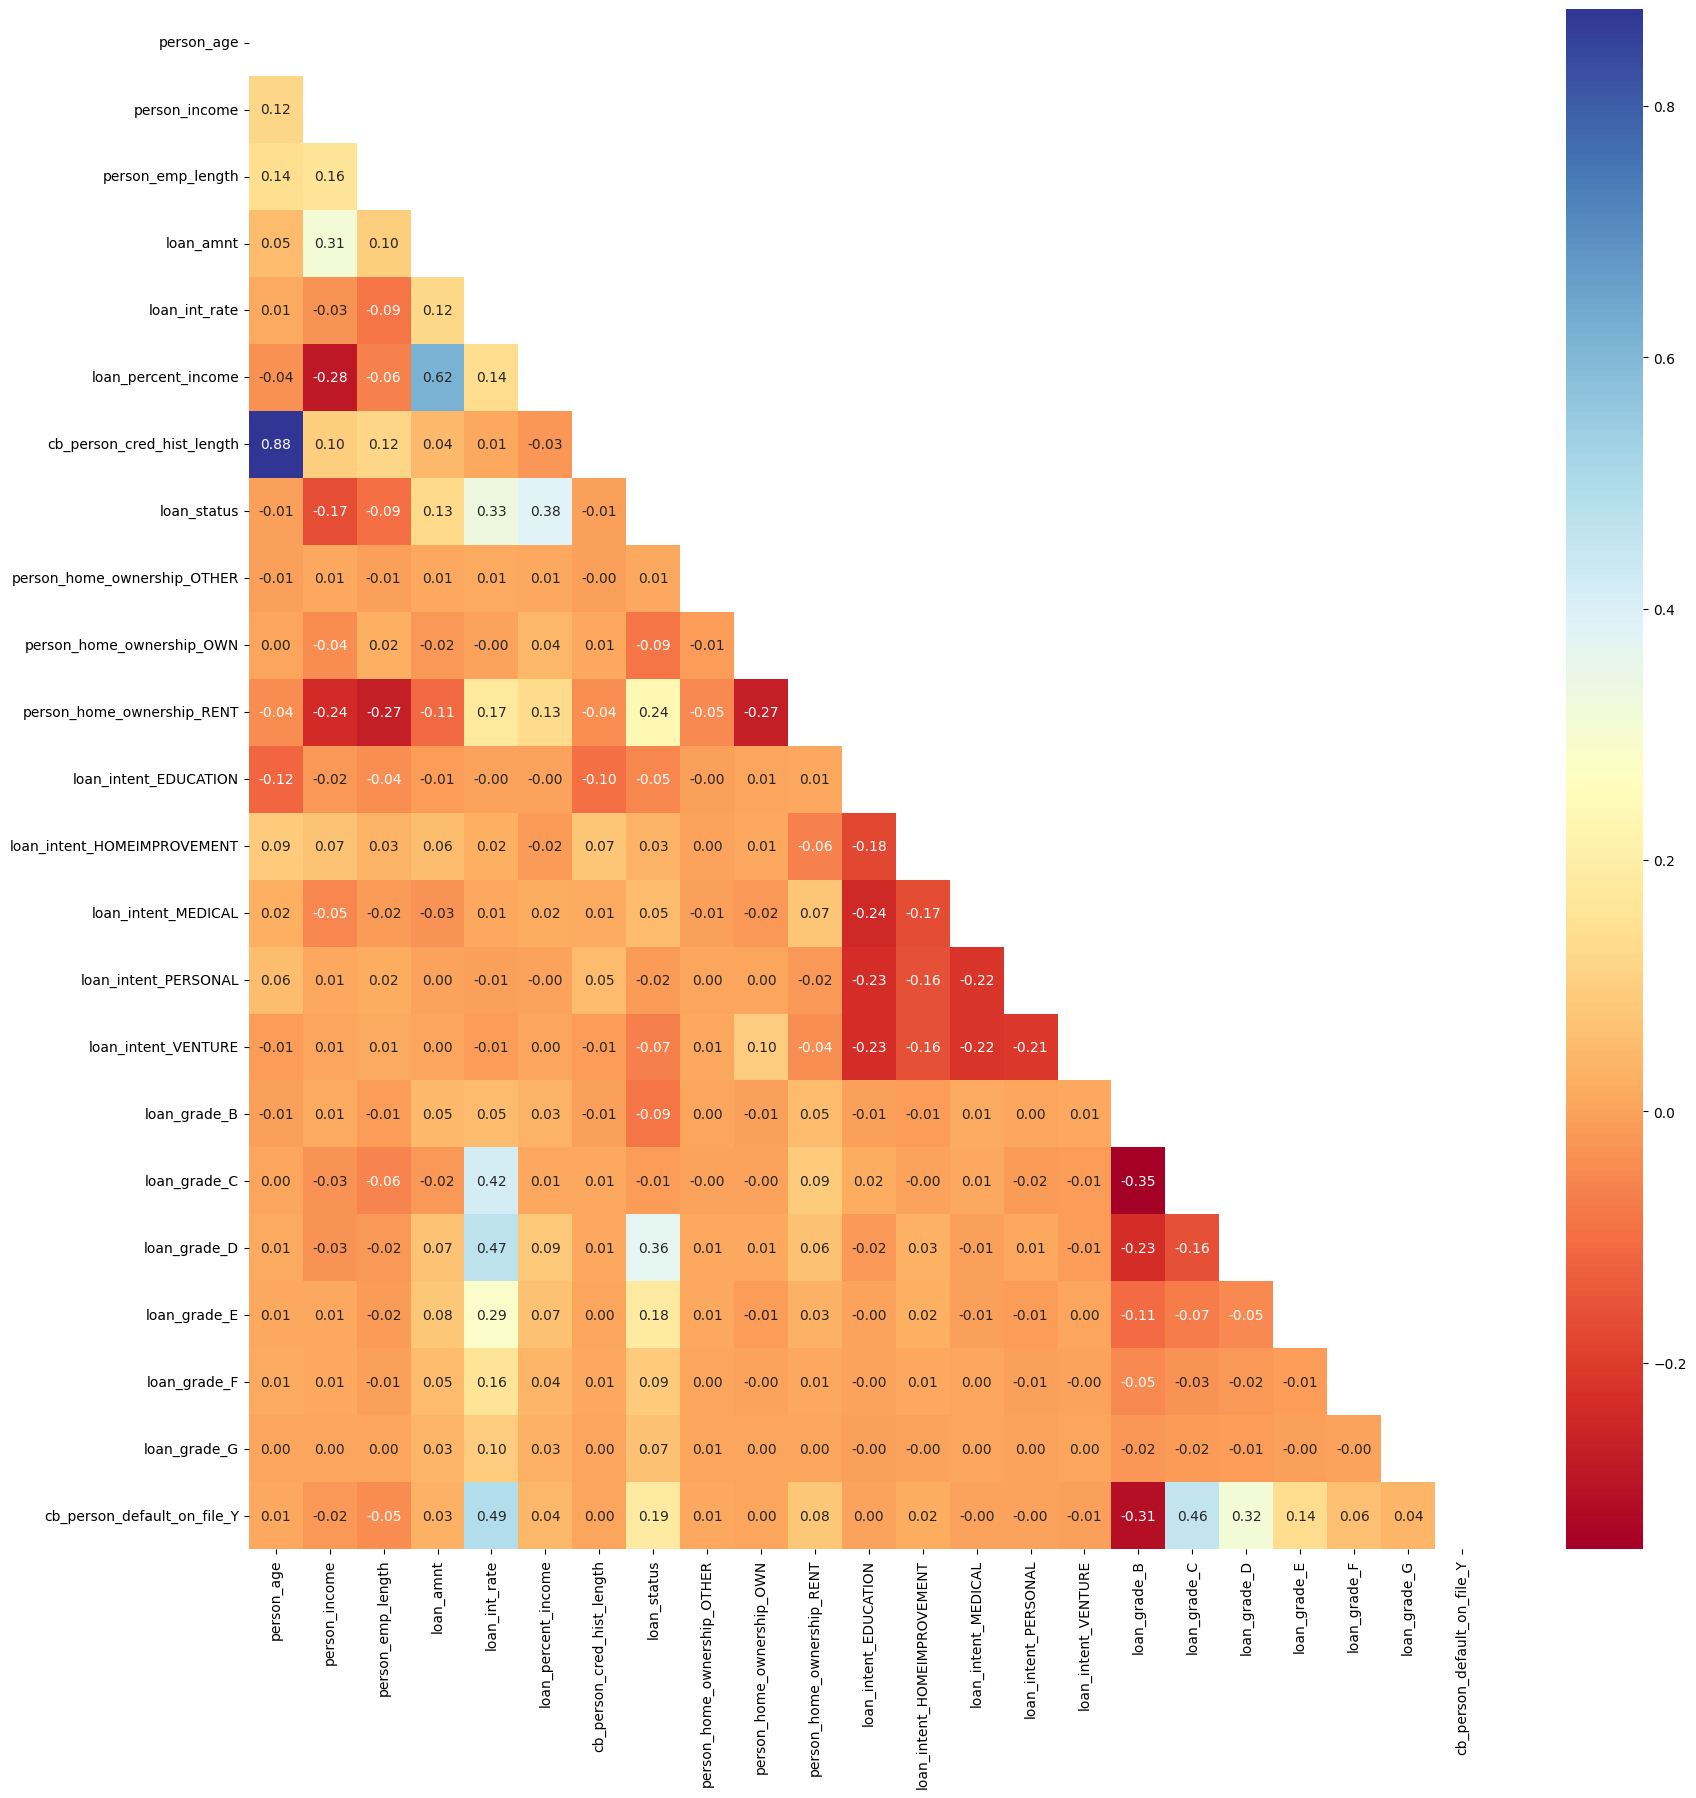

In [45]:
correlation = train.corr()
mask = np.triu(np.ones_like(correlation))
plt.figure(figsize=(20, 20))
sns.heatmap(correlation, cmap='RdYlBu', annot=True, mask=mask, fmt='.2f');

## <span style="color: #B58050">Split data in X and y

In [46]:
X = train.drop(columns=['loan_status'], axis=1)
y = train['loan_status']

## <span style="color: #B58050">Train three different models which are ighly sensitive to outliers: Logistic Regression, SVM (Support Vector Machines) and KNN (K-Nearest Neighbors)

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # SVM classifier
from sklearn.neighbors import KNeighborsClassifier

In [48]:
log_reg = LogisticRegression(penalty='l2', random_state=27)
svm = SVC()
knn = KNeighborsClassifier()

## <span style="color: #B58050">Train models with Optuna and boostings

In [49]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import optuna
from optuna.samplers import TPESampler

# <span style="background-image: url(https://www.kaggle.com/competitions/84894/images/header); color: gold; font-size: 50px; padding: 10px;">XGB Classifier

In [50]:
# %%time
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# def objective(trial):
#     params = {
#         'max_depth': trial.suggest_int('max_depth', 1, 100),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
#         'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
#         'subsample': trial.suggest_float('subsample', 0.01, 1.0, log=True),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0, log=True),
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
#         'eval_metric': 'mlogloss',
#         'use_label_encoder': False,
#         'random_state': 27
#     }
    
#     model = XGBClassifier(**params)
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
#     cv_scores = []

#     for train_index, val_index in skf.split(X_train, y_train):
#         X_cv_train, X_cv_val = X_train.iloc[train_index], X_train.iloc[val_index]
#         y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
#         model.fit(X_cv_train, y_cv_train)
#         y_cv_pred = model.predict(X_cv_val)
#         score = roc_auc_score(y_cv_val, y_cv_pred)
#         cv_scores.append(score)

#     return np.mean(cv_scores)

# optuna.logging.set_verbosity(optuna.logging.WARNING)
# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="xgb", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=50)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
    
"""
Number of finished trials:  40
Best trial:
  Value:  0.8615368395007937
  Params: 
    max_depth: 40
    learning_rate: 0.2174462987892294
    n_estimators: 534
    min_child_weight: 3
    gamma: 5.976300713037911e-05
    subsample: 0.6102333929129401
    colsample_bytree: 0.612352741673944
    reg_alpha: 0.799299665502581
    reg_lambda: 0.00736488994946281
CPU times: user 41min 50s, sys: 16.7 s, total: 42min 7s
Wall time: 10min 53s

Number of finished trials:  100
Best trial:
  Value:  0.8654593113853674
  Params: 
    max_depth: 4
    learning_rate: 0.2159517264330399
    n_estimators: 813
    min_child_weight: 4
    gamma: 1.0400929104594104e-08
    subsample: 0.9048512684003484
    colsample_bytree: 0.5525101181096216
    reg_alpha: 0.00014498405538618866
    reg_lambda: 2.4398395791875457e-08
CPU times: user 1h 55min 34s, sys: 48.5 s, total: 1h 56min 23s
Wall time: 29min 56s

##### Concatenated train + original #####
Number of finished trials:  50  
Best trial:
  Value:  0.8639686158739981
  Params: 
    max_depth: 43
    learning_rate: 0.42576257222865277
    n_estimators: 749
    min_child_weight: 9
    gamma: 1.1669337024772915e-05
    subsample: 0.9097315662154742
    colsample_bytree: 0.6114890625963008
    reg_alpha: 4.761254082318455e-07
    reg_lambda: 0.008602430632882225
CPU times: user 1h 45min 24s, sys: 42.1 s, total: 1h 46min 6s
Wall time: 27min 22s
"""

'\nNumber of finished trials:  40\nBest trial:\n  Value:  0.8615368395007937\n  Params: \n    max_depth: 40\n    learning_rate: 0.2174462987892294\n    n_estimators: 534\n    min_child_weight: 3\n    gamma: 5.976300713037911e-05\n    subsample: 0.6102333929129401\n    colsample_bytree: 0.612352741673944\n    reg_alpha: 0.799299665502581\n    reg_lambda: 0.00736488994946281\nCPU times: user 41min 50s, sys: 16.7 s, total: 42min 7s\nWall time: 10min 53s\n\nNumber of finished trials:  100\nBest trial:\n  Value:  0.8654593113853674\n  Params: \n    max_depth: 4\n    learning_rate: 0.2159517264330399\n    n_estimators: 813\n    min_child_weight: 4\n    gamma: 1.0400929104594104e-08\n    subsample: 0.9048512684003484\n    colsample_bytree: 0.5525101181096216\n    reg_alpha: 0.00014498405538618866\n    reg_lambda: 2.4398395791875457e-08\nCPU times: user 1h 55min 34s, sys: 48.5 s, total: 1h 56min 23s\nWall time: 29min 56s\n\n##### Concatenated train + original #####\nNumber of finished trials: 

# <span style="background-image: url(https://www.kaggle.com/competitions/84894/images/header); color: gold; font-size: 50px; padding: 10px;">CatBoost Classifier

In [51]:
# %%time
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

# def objective(trial):
#     params = {
#         'iterations': trial.suggest_int("iterations", 100, 1000),
#         'learning_rate': trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
#         'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.05, 1.0),
#         'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 100),
#         'depth': trial.suggest_int("depth", 7, 10),
# #         'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#         'verbose': False,
#         'random_state': 27,
#     }        
    
#     model = CatBoostClassifier(**params)
#     skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
#     cv_scores = []

#     for train_index, val_index in skf.split(X_train, y_train):
#         X_cv_train, X_cv_val = X_train.iloc[train_index], X_train.iloc[val_index]
#         y_cv_train, y_cv_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
#         model.fit(X_cv_train, y_cv_train)
#         y_cv_pred = model.predict(X_cv_val)
#         score = roc_auc_score(y_cv_val, y_cv_pred)
#         cv_scores.append(score)

#     return np.mean(cv_scores)

# optuna.logging.set_verbosity(optuna.logging.WARNING)
# sampler = TPESampler(seed=27)
# study = optuna.create_study(study_name="cat", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=50)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")
    
"""
Number of finished trials:  50
Best trial:
  Value:  0.86527792539587
  Params: 
    iterations: 800
    learning_rate: 0.0966060437459555
    colsample_bylevel: 0.9294347573069079
    min_data_in_leaf: 99
    depth: 7
CPU times: user 2h 31min 40s, sys: 27min, total: 2h 58min 40s
Wall time: 50min 55s
"""

'\nNumber of finished trials:  50\nBest trial:\n  Value:  0.86527792539587\n  Params: \n    iterations: 800\n    learning_rate: 0.0966060437459555\n    colsample_bylevel: 0.9294347573069079\n    min_data_in_leaf: 99\n    depth: 7\nCPU times: user 2h 31min 40s, sys: 27min, total: 2h 58min 40s\nWall time: 50min 55s\n'

![](https://wiseloan.com/wp-content/uploads/2022/05/approved-loan-application.jpg)

In [52]:
# best_parameters = trial.params.items()
# best_parameters

In [53]:
# model = XGBClassifier(
#     max_depth = 4,
#     learning_rate = 0.2159517264330399,
#     n_estimators = 813,
#     min_child_weight = 4,
#     gamma = 1.0400929104594104e-08,
#     subsample = 0.9048512684003484,
#     colsample_bytree = 0.5525101181096216,
#     reg_alpha = 0.00014498405538618866,
#     reg_lambda = 2.4398395791875457e-08,
#     random_state = 27,
# )

# model = CatBoostClassifier(
#     iterations = 800,
#     learning_rate = 0.0966060437459555,
#     colsample_bylevel = 0.9294347573069079,
#     min_data_in_leaf = 99,
#     depth = 7,
#     random_state = 27
# )

model = XGBClassifier(
    max_depth = 43,
    learning_rate = 0.42576257222865277,
    n_estimators = 749,
    min_child_weight = 9,
    gamma = 1.1669337024772915e-05,
    subsample = 0.9097315662154742,
    colsample_bytree = 0.6114890625963008,
    reg_alpha = 4.761254082318455e-07,
    reg_lambda = 0.008602430632882225,
    random_state = 27,
)

model.fit(X, y)
y_pred = model.predict_proba(test)

In [54]:
len(y_pred[:, 1])

39098

In [55]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
submission.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


In [56]:
submission['loan_status'] = y_pred[:, 1]
submission.head()

,id,loan_status
0,58645,0.999998
1,58646,0.002540
2,58647,0.983130
3,58648,0.000274
4,58649,0.002334


In [57]:
submission.to_csv('submission.csv', index=False)

In [58]:
print('Good luck with your submission!')

Good luck with your submission!


![](https://www.banking-gateway.com/wp-content/uploads/sites/24/2024/07/105578.Goldman-Sachs.webp)